In [457]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [458]:
import numpy as np
import pandas as pd

In [459]:
import datetime as dt
from dateutil import parser

# Reflect Tables into SQLAlchemy ORM

In [460]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

from flask import Flask, jsonify

In [461]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [462]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [463]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [464]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [465]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [466]:
# last data point
lastentry = str(session.query(Measurement.date).order_by(Measurement.date.desc()).first())
lastentry = lastentry.split(",")[0]
lastentry = lastentry.replace("(", "")
lastentry = lastentry.replace(")", "")
lastentry = lastentry.replace("'", "")
print(lastentry)
last_date = parser.parse(lastentry)

# 1 year ago data point
last_year = dt.date(last_date.year, last_date.month, last_date.day) - dt.timedelta(days=365)
print(last_year)

#precipitation for the full year
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > last_year).\
    order_by(Measurement.date).all()

#save to df
precipitation_df=pd.DataFrame(precipitation_data)
precipitation_df.head()

#change index to date
precipitation_df.set_index('date')
precipitation_df.head(15)

2017-08-23
2016-08-23


,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22
5,2016-08-24,2.15
6,2016-08-24,1.45
7,2016-08-25,0.08
8,2016-08-25,0.08
9,2016-08-25,0.00


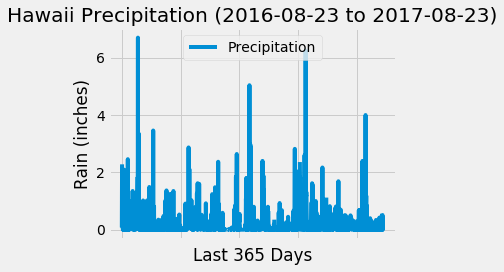

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [467]:
#plot graph
precipitation_df.plot('date', 'prcp')
plt.xlabel("Last 365 Days")
plt.ylabel("Rain (inches)")
plt.title(f"Hawaii Precipitation ({last_year} to {lastentry})")
plt.legend(["Precipitation"],loc='upper center')
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()
precipitation_df.describe()

In [468]:
# Design a query to show how many stations are available in this dataset?
stations_data = session.query(Measurement).group_by(Measurement.station).count()
print(f"Total number of stations: {stations_data}")

Total number of stations: 9


In [469]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_stations_data = session.query(Measurement.station,func.count(Measurement.tobs)).group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).all()

most_active_stations_df = pd.DataFrame(most_active_stations_data, columns=["Station","Observations"])

print("Most Active Stations:")
most_active_stations_df



Most Active Stations:


,Station,Observations
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [470]:
print("Station With Max Observations:")
max_station = most_active_stations_data[0][0]
print(max_station)

Station With Max Observations:
USC00519281


In [471]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temperature_data = session.query(Measurement.station,Measurement.date, Measurement.tobs).\
    filter(Measurement.station == max_station).\
    filter(Measurement.date > last_year).\
    order_by(Measurement.date).all()
#save to df
temperatures_df = pd.DataFrame(temperature_data)
temperatures_df.head()

,station,date,tobs
0,USC00519281,2016-08-24,77.0
1,USC00519281,2016-08-25,80.0
2,USC00519281,2016-08-26,80.0
3,USC00519281,2016-08-27,75.0
4,USC00519281,2016-08-28,73.0


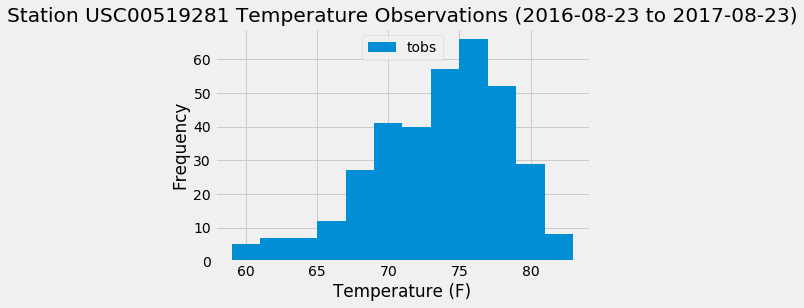

In [472]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
plt.hist(temperatures_df['tobs'],12)
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.title(f"Station {max_station} Temperature Observations ({last_year} to {lastentry})")
plt.legend(["tobs"],loc='upper center')
plt.show()

## Optional Challenge Assignment

In [473]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    temp_list = []
    temp_list = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
    
    return temp_list 

# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
myTripStartDate = '2016-08-25'
myTripEndDate = '2016-08-27'
myTripTempCalcs = []
myTripTempCalcs = calc_temps(myTripStartDate, myTripEndDate)
print(myTripTempCalcs)

[(73.0, 78.94736842105263, 84.0)]


Average Temp = 78.94736842105263
Temp Range = (tmax 84.0 - tmin 73.0) / 2 = +/- 5.5


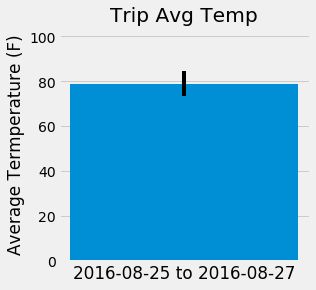

In [474]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

index = np.arange(len(myTripTempCalcs))

Tav = myTripTempCalcs[0][1]
Tmin = myTripTempCalcs[0][0]
Tmax = myTripTempCalcs[0][2]

Terror = (Tmax-Tmin) / 2

print(f"Average Temp = {Tav}")
print(f"Temp Range = (tmax {Tmax} - tmin {Tmin}) / 2 = +/- {Terror}")

fig, ax = plt.subplots(figsize=(4,4))
ax.set_xticks(index)
ax.set_xticklabels(df1.columns)
ax.bar(3, Tav, yerr=Terror, capsize=0)
ax.set_ylim(0, Tmax + 20)
plt.xlabel(f"{myTripStartDate} to {myTripEndDate}")
plt.ylabel("Average Termperature (F)")
plt.title(f"Trip Avg Temp")
plt.show()


In [475]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [559]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
trip_dates = ('08-25', '08-26', '08-27')

item_counter = 1
day_counter = 0

Date_Range_Normals_df = pd.DataFrame(columns = trip_dates)
for day in trip_dates:
    temp_list = daily_normals(day)
    normals1 = []
    normals2 = []
    normals3 = []
    for temps in temp_list:
              
        print(f"{day}:{temps}")
        for item in temps:
            
            if item_counter == 1:
                normals1.append(item)
            if item_counter == 2:
                normals2.append(item)
            if item_counter == 3:
                normals3.append(item)
            print(item)
            item_counter = item_counter + 1
    print(day_counter)
    Date_Range_Normals_df[day_counter] = normals1, normals2, normals3  
    day_counter = day_counter + 1
 
    print()




08-25:(69.0, 76.96078431372548, 82.0)
69.0
76.96078431372548
82.0
0

08-26:(71.0, 76.56862745098039, 84.0)
71.0
76.56862745098039
84.0
1

08-27:(68.0, 76.28301886792453, 84.0)
68.0
76.28301886792453
84.0
2



In [560]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
#Date_Range_Normals_df.rename_axis('date') 
Date_Range_Normals_df

,08-25,08-26,08-27,0,1,2
0,NaN,NaN,NaN,"(69.0,)",(),()
1,NaN,NaN,NaN,"(76.96078431372548,)",(),()
2,NaN,NaN,NaN,"(82.0,)",(),()


([<matplotlib.axis.XTick at 0x11b17d04358>,
 <a list of 3 Text xticklabel objects>)

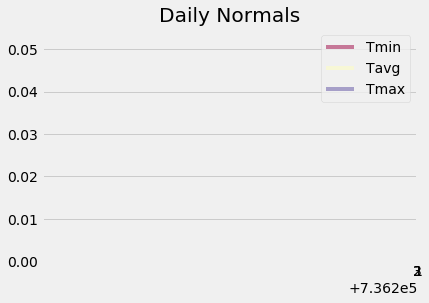

In [561]:
# Plot the daily normals as an area plot with `stacked=False`

dates =  ['2016-08-25','2016-08-26','2016-08-27']
x = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in dates]
Date_Range_Normals_df.plot(kind='area', stacked=False, alpha=0.5, colormap='Spectral', title='Daily Normals')
[ax.legend(('Tmin', 'Tavg', 'Tmax'), loc='upper right') for ax in plt.gcf().axes]
plt.xticks(x)


In [555]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

